# Predicting Road Accident Risk
In this notebook, we will be predicting the risk of road accidents based on the given dataset. You can find the competition and the dataset [here](https://www.kaggle.com/competitions/playground-series-s5e10).

<div align="center">
<img src="https://www.kaggle.com/competitions/91721/images/header" />
</div>

## 1. Importing Libraries

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import lightgbm as lgb
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score, mean_squared_error

import warnings

### Configurations

In [27]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('darkgrid')

## 2. Loading Data

In [28]:
df = pd.read_csv('train.csv', index_col='id')

In [29]:
df.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [30]:
df.shape

(517754, 13)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 517754 entries, 0 to 517753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 41.5+ MB


In [32]:
df.isnull().sum()

road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

## 3. Exploratory Data Analysis

In [33]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_lanes,517754.0,2.491511,1.120434,1.0,1.00,2.00,3.00,4.0
curvature,517754.0,0.488719,0.272563,0.0,0.26,0.51,0.71,1.0
speed_limit,517754.0,46.112575,15.788521,25.0,35.00,45.00,60.00,70.0
num_reported_accidents,517754.0,1.187970,0.895961,0.0,1.00,1.00,2.00,7.0
accident_risk,517754.0,0.352377,0.166417,0.0,0.23,0.34,0.46,1.0


In [34]:
# First, check duplicates
df.duplicated().sum()

np.int64(656)

In [35]:
df.drop_duplicates(inplace=True)

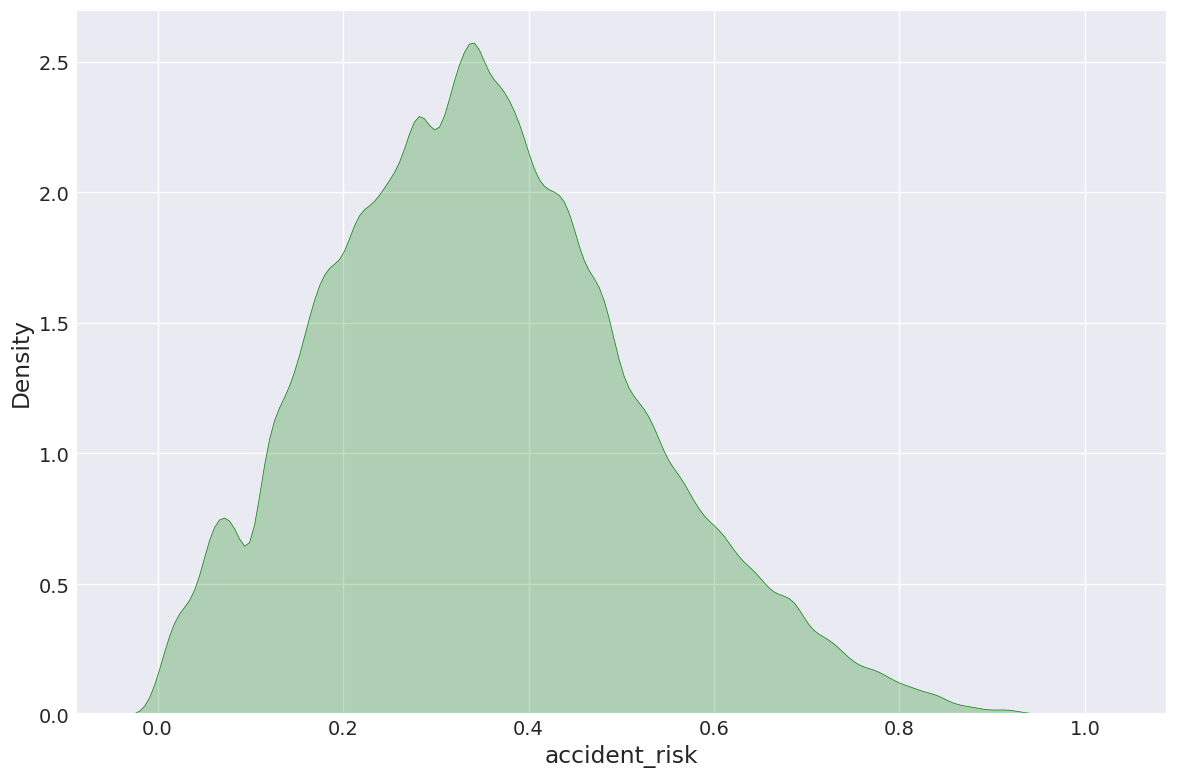

In [36]:
sns.kdeplot(df['accident_risk'], fill=True, color='g')
plt.tight_layout()

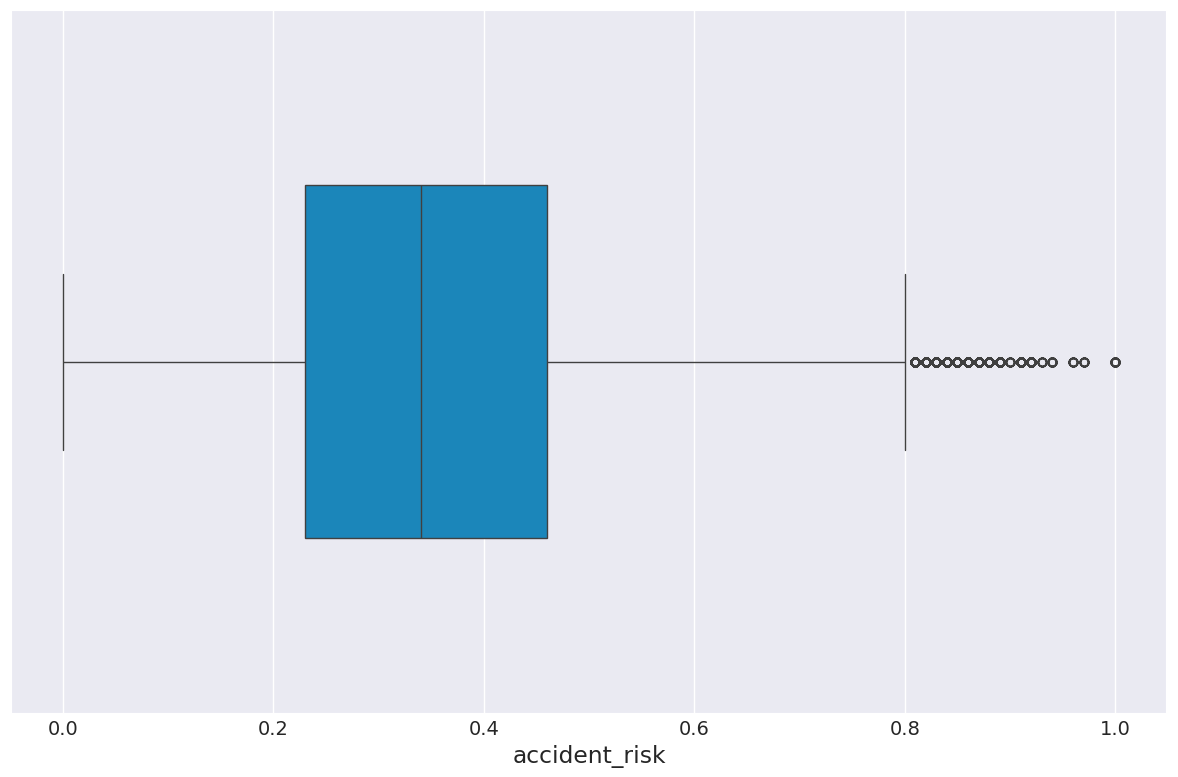

In [37]:
sns.boxplot(df['accident_risk'], orient='h', width=0.5)
plt.tight_layout()

<Axes: >

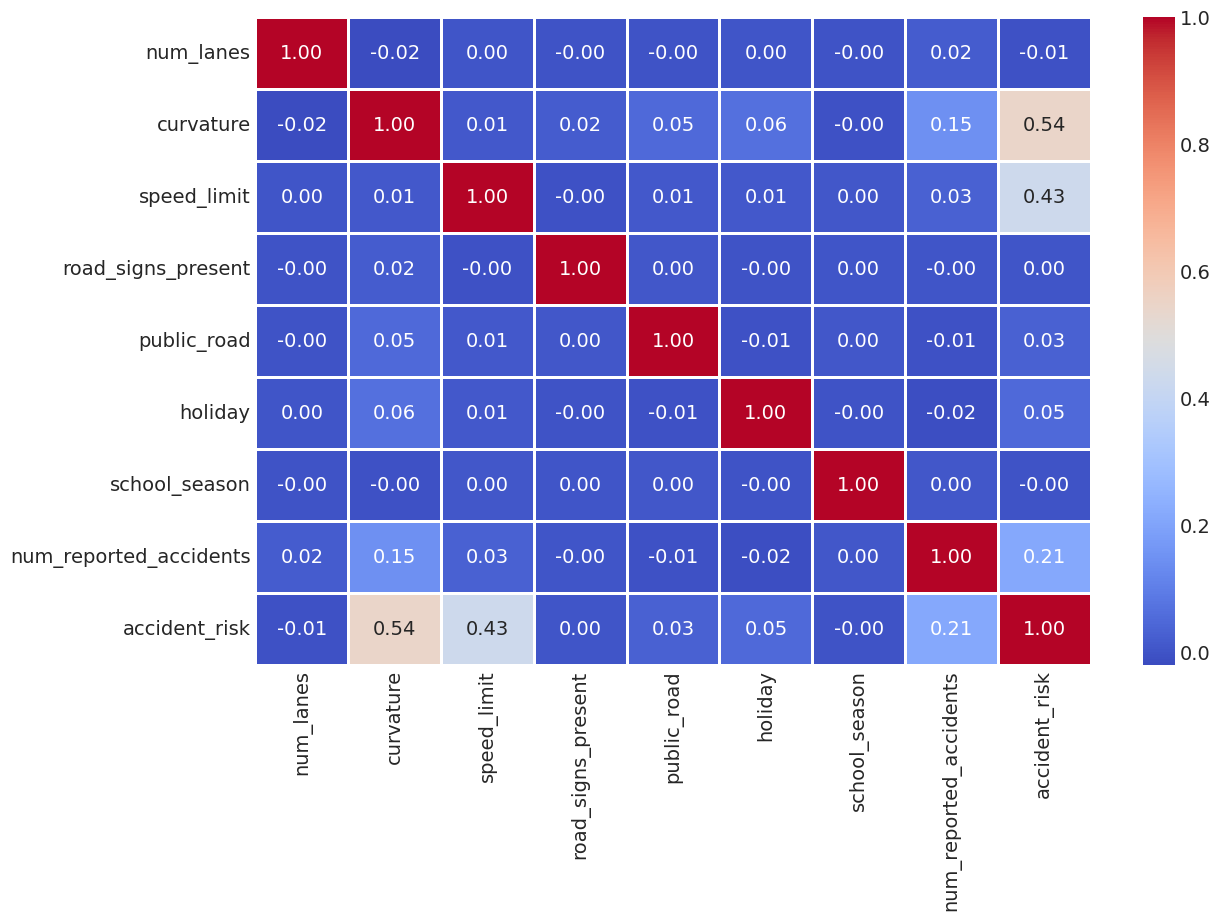

In [38]:
# Numerical features correlation
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm', linewidths=1)

In [39]:
cat_cols = df.select_dtypes(exclude="number").columns.tolist()
cat_cols

['road_type',
 'lighting',
 'weather',
 'road_signs_present',
 'public_road',
 'time_of_day',
 'holiday',
 'school_season']

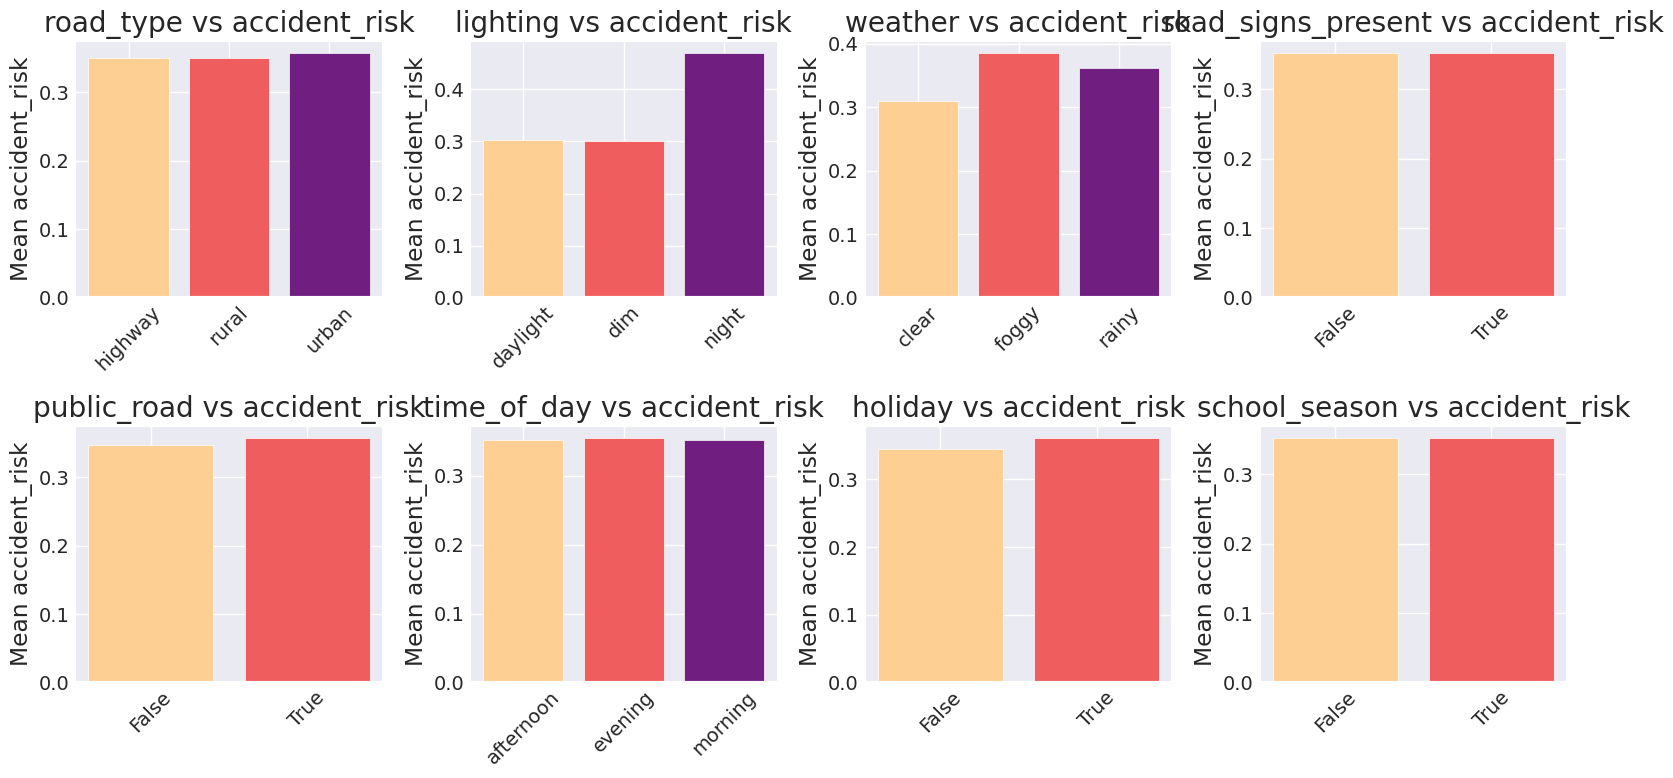

In [40]:
fig , axes = plt.subplots(2, 4, figsize=(16,8))
axes = axes.flatten()
cmap = plt.get_cmap('magma')
colors = cmap([0.9,0.66,0.33])
target = 'accident_risk'

for i,col in enumerate(cat_cols):
    grouped = df.groupby(col)[target].mean()
    axes[i].bar(grouped.index.astype(str), grouped.values , color=colors)
    axes[i].set_ylabel(f'Mean {target}')
    axes[i].set_title(f'{col} vs {target}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

### Handling dtypes

In [41]:
# boolean
bool_cols = df.select_dtypes(include=['bool']).columns
for col in bool_cols:
    df[col] = df[col].astype(int)

In [42]:
# categorical
df = df.astype({
    'road_type': 'category',
    'lighting': 'category',
    'weather': 'category',
    'time_of_day': 'category',
})

### Seperating features and target

In [43]:
X = df.drop('accident_risk', axis=1)
y = df[['accident_risk']]

### Encoding & Scaling

In [44]:
x_dummies = pd.get_dummies(X)

In [45]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_dummies)

### Split as train and test

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [47]:
x_train.shape

(413678, 20)

## 5. Model Training

In [48]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "ExtraTreeRegressor": ExtraTreeRegressor(),
    "LightGBM": lgb.LGBMRegressor(verbose=0),
    "XGBoost": xgb.XGBRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
}


def evaluate(x_train, y_train, x_test, y_test):
    results = []
    for name, model in tqdm(models.items()):
        print(f"Training {name} model...")
        y_pred = model.fit(x_train, y_train).predict(x_test)
        
        results.append({
            "Model": name,
            "R2_Score": r2_score(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "RMSE": mean_squared_error(y_test, y_pred)**0.5
        })
    report = pd.DataFrame(results).sort_values('R2_Score', ascending=False)
    report.reset_index(drop=True, inplace=True)
    return report

In [49]:
evaluate(x_train, y_train, x_test, y_test)

  0%|          | 0/8 [00:00<?, ?it/s]

Training LinearRegression model...
Training Ridge model...
Training Lasso model...
Training DecisionTreeRegressor model...
Training ExtraTreeRegressor model...
Training LightGBM model...
Training XGBoost model...
Training GradientBoostingRegressor model...


,Model,R2_Score,MSE,RMSE
0,XGBoost,0.886660,0.003139,0.056027
1,LightGBM,0.886527,0.003143,0.056060
2,GradientBoostingRegressor,0.883750,0.003220,0.056742
3,LinearRegression,0.804370,0.005418,0.073608
4,Ridge,0.804370,0.005418,0.073608
5,DecisionTreeRegressor,0.751885,0.006872,0.082896
6,ExtraTreeRegressor,0.751622,0.006879,0.082940
7,Lasso,-0.000010,0.027696,0.166422


## 6. Build Pipeline with the best model, Save the model, Make Submission

In [59]:
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(), X.select_dtypes(include='category').columns),
    ('scaler', MinMaxScaler(), X.select_dtypes(include='number').columns)
])

In [60]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(random_state=42))
])
pipeline.fit(X, y)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('encoder', ...), ('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [62]:
y_pred = pipeline.predict(X)

print(f'R2 Score : {r2_score(y, y_pred)}')
print(f'MSE      : {mean_squared_error(y, y_pred)}')
print(f'RMSE     : {mean_squared_error(y, y_pred)**0.5}')

R2 Score : 0.8888790607452393
MSE      : 0.00307757337577641
RMSE     : 0.055475881027491666


In [63]:
# Save the model
joblib.dump(pipeline, 'road_accident_risk_pipeline.pkl')

['road_accident_risk_pipeline.pkl']

In [68]:
# Make Submission
test_df = pd.read_csv('test.csv', index_col='id')

predictions = pipeline.predict(test_df)
submission = pd.DataFrame({
    'id': test_df.index,
    'accident_risk': predictions
})
submission.head()

,id,accident_risk
0,517754,0.293221
1,517755,0.122790
2,517756,0.188757
3,517757,0.309009
4,517758,0.406114


In [69]:
submission.to_csv('submission.csv', index=False)

## 7. Conclusion
We built an end-to-end pipeline to predict road accident risk, explored key features, and compared models. XGBoost delivered the best performance after tuning, so we used it to generate test predictions and a valid submission file. Future improvements could focus on richer feature engineering, handling class imbalance, and calibration to further boost reliability.